In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
def sign(x):
    return (x >= 0).astype(int)*2 - 1

In [37]:
d = 2
w = np.random.randn(d)
# X = np.column_stack([
#     np.linspace(-10., 10., 201),
#     np.ones((201, d-1))
# ])
X = np.random.randn(2000, d) * 10. - 5. 
X.shape, w

((2000, 2), array([ 1.24975816, -1.58432837]))

In [38]:
Y = sign(X @ w)
Y.shape

(2000,)

In [5]:
from typing import Literal, Mapping
from numpy import ndarray
from numpy.random import RandomState
from sklearn.linear_model import LogisticRegression

class LogisticRegressionButBetter(LogisticRegression):
    def __init__(self, penalty: Literal['l1', 'l2', 'elasticnet'] | None = "l2", *, dual: bool = False, tol: float = 0.0001, C: float = 1, fit_intercept: bool = True, intercept_scaling: float = 1, class_weight: Mapping | str | None = None, random_state: int | RandomState | None = None, solver: Literal['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'] = "lbfgs", max_iter: int = 100, multi_class: Literal['auto', 'ovr', 'multinomial'] = "auto", verbose: int = 0, warm_start: bool = False, n_jobs: int | None = None, l1_ratio: float | None = None) -> None:
        super().__init__(penalty, dual=dual, tol=tol, C=C, fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, class_weight=class_weight, random_state=random_state, solver=solver, max_iter=max_iter, multi_class=multi_class, verbose=verbose, warm_start=warm_start, n_jobs=n_jobs, l1_ratio=l1_ratio)
        self.fit_success = True
        self.default_pred = 1.
    
    def fit(self, X, y, sample_weight = None) -> None:
        try:
            self.fit_success = True
            super().fit(X, y, sample_weight)
        except:
            self.fit_success = False
            self.default_pred = 1. 
            if y is not None and len(y) > 0:
                self.default_pred = y[0]
    
    def predict(self, X) -> ndarray:
        if self.fit_success:
            return super().predict(X)
        else:
            return np.ones(len(X)) * self.default_pred
    
    def predict_proba(self, X) -> ndarray:
        if self.fit_success:
            return super().predict_proba(X)
        else:
            if self.default_pred == 1.:
                return np.column_stack([
                    np.zeros(len(X)),
                    np.ones(len(X))
                ])
            else:
                return np.column_stack([
                    np.ones(len(X)),
                    np.zeros(len(X))
                ])

In [47]:
from modAL.models import ActiveLearner, Committee
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from modAL.disagreement import vote_entropy_sampling, max_disagreement_sampling, consensus_entropy_sampling

n_members = 10
n_byzantine = 4
byzantine_flip_proba = 0.5 
good_agents = np.arange(n_members)
if n_byzantine >= 1:
    good_agents = np.random.choice(np.arange(n_members), size=n_members-n_byzantine, replace=False)
    good_agents.sort()
learners = []


for i in range(n_members):
    learner = ActiveLearner(
        # estimator=LogisticRegression(penalty=None, fit_intercept=False, solver='saga', max_iter=1000),
        # estimator=LogisticRegression(penalty=None, fit_intercept=False),
        estimator=LogisticRegressionButBetter(penalty=None, fit_intercept=False),
        # estimator=SGDClassifier(loss='log_loss', penalty=None, fit_intercept=False, learning_rate='constant', eta0=1e-1),
        # estimator=RandomForestClassifier(),
        X_training=np.concatenate([X[0].reshape(1, -1), X[-1].reshape(1, -1)], axis=0),
        y_training=np.array([Y[0], Y[-1]]),
        bootstrap_init=True
    )
    learners.append(learner)

committee = Committee(learners, vote_entropy_sampling)
good_agents

array([2, 3, 4, 6, 7, 8])

In [48]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

perf_hist = [committee.score(X, Y)]
total_perf_hist = [committee.score(X, Y)]
n_queries = 50
X_pool = X.copy()[1:-1]
Y_pool = Y.copy()[1:-1]
X_seen = np.array([X.copy()[0], X.copy()[-1]])
Y_seen = np.array([Y.copy()[0], Y.copy()[-1]])
# X_pool = X.copy()
# Y_pool = Y.copy()
# X_seen = np.empty((1, d))
# Y_seen = np.empty((1,))
queries = []

for i in range(n_queries):
    # Try adding committee.rebag() here or after teach
    committee.rebag() 
    query_idx, query_instance = committee.query(X_pool, random_tie_break=True)
    queries.append(query_instance)
    X_seen = np.concatenate([X_seen, X_pool[query_idx].reshape(1, -1)], axis=0)
    Y_seen = np.concatenate([Y_seen, Y_pool[query_idx]])
    # committee.teach(X=X_pool[query_idx].reshape(1, -1), y=Y_pool[query_idx].reshape(1,))
    for j in range(n_members):
        if j not in good_agents and np.random.rand() <= byzantine_flip_proba:
            committee.learner_list[j].fit(X=X_seen, y=-Y_seen)
        elif j not in good_agents:
            committee.learner_list[j].fit(X=X_seen, y=Y_seen)
        else:
            committee.learner_list[j].teach(X=X_pool[query_idx].reshape(1, -1), y=Y_pool[query_idx].reshape(1,))
    good_learners = [
        committee.learner_list[good_index].estimator for good_index in good_agents
    ]
    preds = sign(np.column_stack([
        good_learner.predict(X) for good_learner in good_learners
    ]).sum(axis=1))
    perf_hist.append(accuracy_score(Y, preds))
    total_perf_hist.append(committee.score(X, Y))

    X_pool = np.delete(X_pool, query_idx, axis=0)
    Y_pool = np.delete(Y_pool, query_idx)

In [49]:
# good_learners[0].estimator.coef_ / (good_learners[0].estimator.coef_[0, 1] / w[1])
learned_wts = np.concatenate([learner.estimator.coef_ for learner in committee.learner_list], axis=0)
learned_wts /= (learned_wts[:, 1] / w[1]).reshape(-1, 1)
print(w)
# print(learned_wts)
for i in range(n_members):
    print('Good' if i in good_agents else 'Byzantine', learned_wts[i])

[ 1.24975816 -1.58432837]
Byzantine [ 1.25942124 -1.58432837]
Byzantine [ 1.25942124 -1.58432837]
Good [ 1.25942124 -1.58432837]
Good [ 1.25942124 -1.58432837]
Good [ 1.25942124 -1.58432837]
Byzantine [ 1.25942124 -1.58432837]
Good [ 1.25942124 -1.58432837]
Good [ 1.25942124 -1.58432837]
Good [ 1.25942124 -1.58432837]
Byzantine [ 1.25942124 -1.58432837]


The problem is that flipping the class labels is useless. The same information is present with the learners, be they good or bad. Unless there are nearly 50-50 good and bad, the presence of learners with similar weights (but flipped) is good enough to get the required information. 

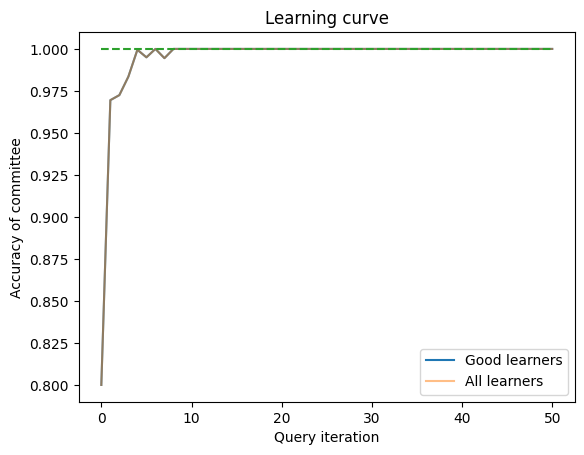

In [50]:
plt.plot(range(n_queries+1), perf_hist, label='Good learners')
plt.plot(range(n_queries+1), total_perf_hist, label='All learners', alpha=0.5)
plt.plot(range(n_queries+1), np.ones((n_queries+1,)), linestyle='dashed')
plt.xlabel('Query iteration')
plt.ylabel('Accuracy of committee')
plt.title('Learning curve')
plt.legend()
plt.show()

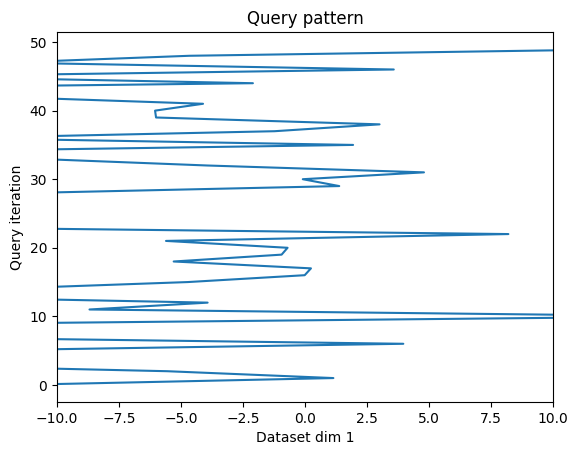

In [51]:
plt.plot(np.array(queries)[:, 0, 0], range(n_queries))
plt.xlim(-10, 10)
plt.xlabel('Dataset dim 1')
plt.ylabel('Query iteration')
plt.title('Query pattern')
plt.show()

In [138]:
perf_hist

[0.9303482587064676,
 0.9900497512437811,
 0.9800995024875622,
 0.9950248756218906,
 1.0,
 1.0,
 1.0,
 0.9950248756218906,
 0.9900497512437811,
 0.9900497512437811,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9950248756218906,
 0.9900497512437811,
 0.9950248756218906,
 0.9950248756218906,
 0.9900497512437811,
 0.9900497512437

In [79]:
np.array(queries).shape

(50, 1, 2)

In [70]:
queries

[array([[-9.9,  1. ]]),
 array([[0.6, 1. ]]),
 array([[-2.1,  1. ]]),
 array([[-0.6,  1. ]]),
 array([[-1.5,  1. ]]),
 array([[-0.1,  1. ]]),
 array([[-0.2,  1. ]]),
 array([[-0.4,  1. ]]),
 array([[-0.3,  1. ]]),
 array([[-0.5,  1. ]]),
 array([[-1.4,  1. ]]),
 array([[-1.6,  1. ]]),
 array([[-1.1,  1. ]]),
 array([[-1.2,  1. ]]),
 array([[-0.7,  1. ]]),
 array([[-1.,  1.]]),
 array([[-0.8,  1. ]]),
 array([[-0.9,  1. ]]),
 array([[0., 1.]]),
 array([[0.1, 1. ]]),
 array([[-1.3,  1. ]]),
 array([[0.2, 1. ]]),
 array([[-1.7,  1. ]]),
 array([[0.3, 1. ]]),
 array([[0.4, 1. ]]),
 array([[-1.8,  1. ]]),
 array([[-1.9,  1. ]]),
 array([[0.5, 1. ]]),
 array([[0.7, 1. ]]),
 array([[-2.,  1.]]),
 array([[0.8, 1. ]]),
 array([[-2.2,  1. ]]),
 array([[0.9, 1. ]]),
 array([[1., 1.]]),
 array([[-2.3,  1. ]]),
 array([[-2.4,  1. ]]),
 array([[1.1, 1. ]]),
 array([[-2.5,  1. ]]),
 array([[1.2, 1. ]]),
 array([[-2.6,  1. ]]),
 array([[-2.7,  1. ]]),
 array([[1.3, 1. ]]),
 array([[1.4, 1. ]]),
 array